# Preprocessing & EDA

We begin by loading in our helper script with some styling information and a plot function before preprocessing & analysing the data

In [ ]:
import os, sys
%load_ext autoreload
%autoreload 2

src = '/Users/richardlastrucci/Library/Mobile Documents/com~apple~CloudDocs/University/Honours/Semester 2/COS 781/project/src'
sys.path.append(src)
import helper as h 

In [ ]:
import pandas as pd, numpy as np
path = '/Users/richardlastrucci/Library/Mobile Documents/com~apple~CloudDocs/University/Honours/Semester 2/COS 781/project/data/intermediate'
ogdf = pd.read_json(f'{path}/reviews_sample.json', lines=True) # load original sample of 3 000 000 rows

In [ ]:
df = ogdf 
df.columns 

Index(['user_id', 'book_id', 'rating', 'review_text', 'date_added', 'title'], dtype='object')

## Brute force subset 

Here we select users with more than 110 ratings and books with more than 70 rating

In [ ]:

user_threshold = 110 
book_threshold = 70 

user_counts = df['user_id'].value_counts()
filtered_users = user_counts[user_counts >= user_threshold].index
df_filtered_users = df[df['user_id'].isin(filtered_users)]

book_counts = df_filtered_users['book_id'].value_counts()
filtered_books = book_counts[book_counts >= book_threshold].index
df_filtered = df_filtered_users[df_filtered_users['book_id'].isin(filtered_books)]

df_filtered_shape = df_filtered.shape
print(len(df_filtered.user_id.unique()), len(df_filtered.book_id.unique()), df_filtered_shape)


1701 44 (4186, 5)


In [21]:
df = df_filtered


In [ ]:
missing_values = df.isnull().sum() # check for missing values
missing_values


user_id       0
book_id       0
rating        0
date_added    0
title         0
dtype: int64

In [ ]:
df['date_added'] = pd.to_datetime(df['date_added'], format='%a %b %d %H:%M:%S %z %Y') # convering the date field

/var/folders/_l/n6074lxj74q0qp0r36bcr6_00000gn/T/ipykernel_99703/4250930182.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date_added'] = pd.to_datetime(df['date_added'], format='%a %b %d %H:%M:%S %z %Y')
/var/folders/_l/n6074lxj74q0qp0r36bcr6_00000gn/T/ipykernel_99703/4250930182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_added'] = pd.to_datetime(df['date_added'], format='%a %b %d %H:%M:%S %z %Y')


In [ ]:
df.date_added # confirming the date conversion

721        2013-01-11 07:33:21-08:00
813        2010-03-16 09:41:53-07:00
985        2011-04-01 12:53:01-07:00
1012       2012-01-11 11:17:08-08:00
2021       2010-11-30 11:48:42-08:00
                     ...            
2994059    2010-04-19 12:41:23-07:00
2994104    2013-10-04 00:01:27-07:00
2996599    2010-06-18 05:11:29-07:00
2997866    2010-06-15 02:00:00-07:00
2999413    2010-03-10 05:41:47-08:00
Name: date_added, Length: 4186, dtype: object

In [ ]:
df.rating.value_counts() # get the rating counts

rating
5    1477
4    1452
3     751
2     285
0     118
1     103
Name: count, dtype: int64

In [ ]:
df.rating.describe() # get the rating distribution

count    4186.000000
mean        3.850693
std         1.206284
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

### plotting the rating distribution

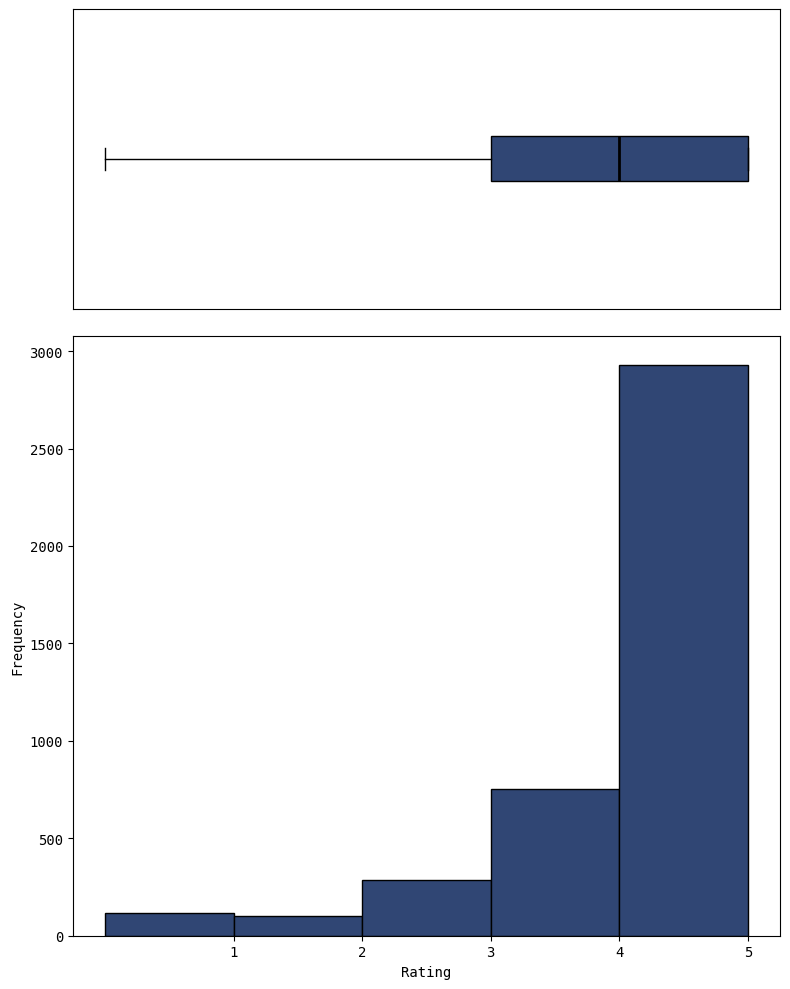

In [ ]:
import matplotlib.pyplot as plt

fig, (ax_box, ax_hist) = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(8, 10), 
    gridspec_kw={"height_ratios": [1.5, 3]}  
)

boxplot = ax_box.boxplot(
    df['rating'], 
    vert=False, 
    patch_artist=True,
)
for box in boxplot['boxes']:
    box.set(facecolor=h.deep)
for median in boxplot['medians']:
    median.set(color='black', linewidth=2)

ax_box.get_yaxis().set_visible(False)
ax_box.get_xaxis().set_visible(False)  

ax_hist.hist(df['rating'], bins=5, edgecolor='black', color=h.deep)
ax_hist.set_xlabel('Rating')
ax_hist.set_ylabel('Frequency')
ax_hist.set_xticks(range(1, 6))


plt.tight_layout(h_pad=2) 
plt.show()


### plotting the ratings per user

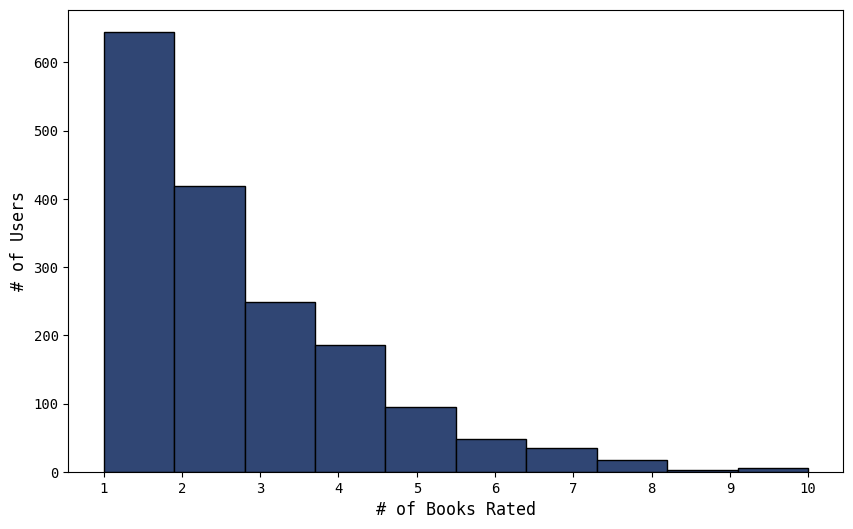

In [ ]:
user_rating_counts = df.groupby('user_id').size()

plt.figure(figsize=(10, 6))
plt.hist(user_rating_counts, color=h.deep, edgecolor='black')
plt.xlabel('# of Books Rated', fontsize=12)
plt.ylabel('# of Users', fontsize=12)
plt.xticks(range(1, user_rating_counts.max() + 1))
plt.show()

### save the cleaned dataset

In [29]:
df = df[['user_id','book_id','rating', 'date_added', 'title']]

path = '/Users/richardlastrucci/Library/Mobile Documents/com~apple~CloudDocs/University/Honours/Semester 2/COS 781/project/data/preprocessed'

df.to_json(f'{path}/reviews_sample_cleaned.json', orient='records')

### construct the sparse utility matrix

In [30]:
from scipy.sparse import csr_matrix

rows = df['user_id'].astype('category').cat.codes
cols = df['book_id'].astype('category').cat.codes
values = df['rating']

utility_matrix = csr_matrix((values, (rows, cols)))
total_elements = utility_matrix.shape[0] * utility_matrix.shape[1]

non_zero_elements = utility_matrix.nnz

sparsity = 1 - (non_zero_elements / total_elements)
print(f"Matrix dimensions: {utility_matrix.shape}")
print(f"Matrix sparsity: {sparsity:.4%}")


Matrix dimensions: (1701, 44)
Matrix sparsity: 94.4070%


### normalise the matrix

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_matrix = scaler.fit_transform(utility_matrix.toarray().T).T

### Mask some values and save them as a test set

In [36]:
import numpy as np
import pandas as pd

matrix = normalized_matrix
non_zero_indices = np.nonzero(matrix)
total = len(non_zero_indices[0])
to_mask = round(total * 0.2)

coordinate_pairs = list(zip(non_zero_indices[0], non_zero_indices[1]))
random_indices = np.random.choice(len(coordinate_pairs), to_mask, replace=False)

pairs_to_mask = np.array(coordinate_pairs)[random_indices]
masked_values = [(row, col, matrix[row, col]) for row, col in pairs_to_mask]

for row, col in pairs_to_mask:
    matrix[row, col] = 0

path = "/Users/richardlastrucci/Library/Mobile Documents/com~apple~CloudDocs/University/Honours/Semester 2/COS 781/project/data/application"

pd.DataFrame(matrix).to_csv(f'{path}/train.csv', index=False, header=False)

masked_df = pd.DataFrame(masked_values, columns=['r', 'c', 'v'])
masked_df.to_csv(f'{path}/test.csv', index=False)


### plot the utility matrix

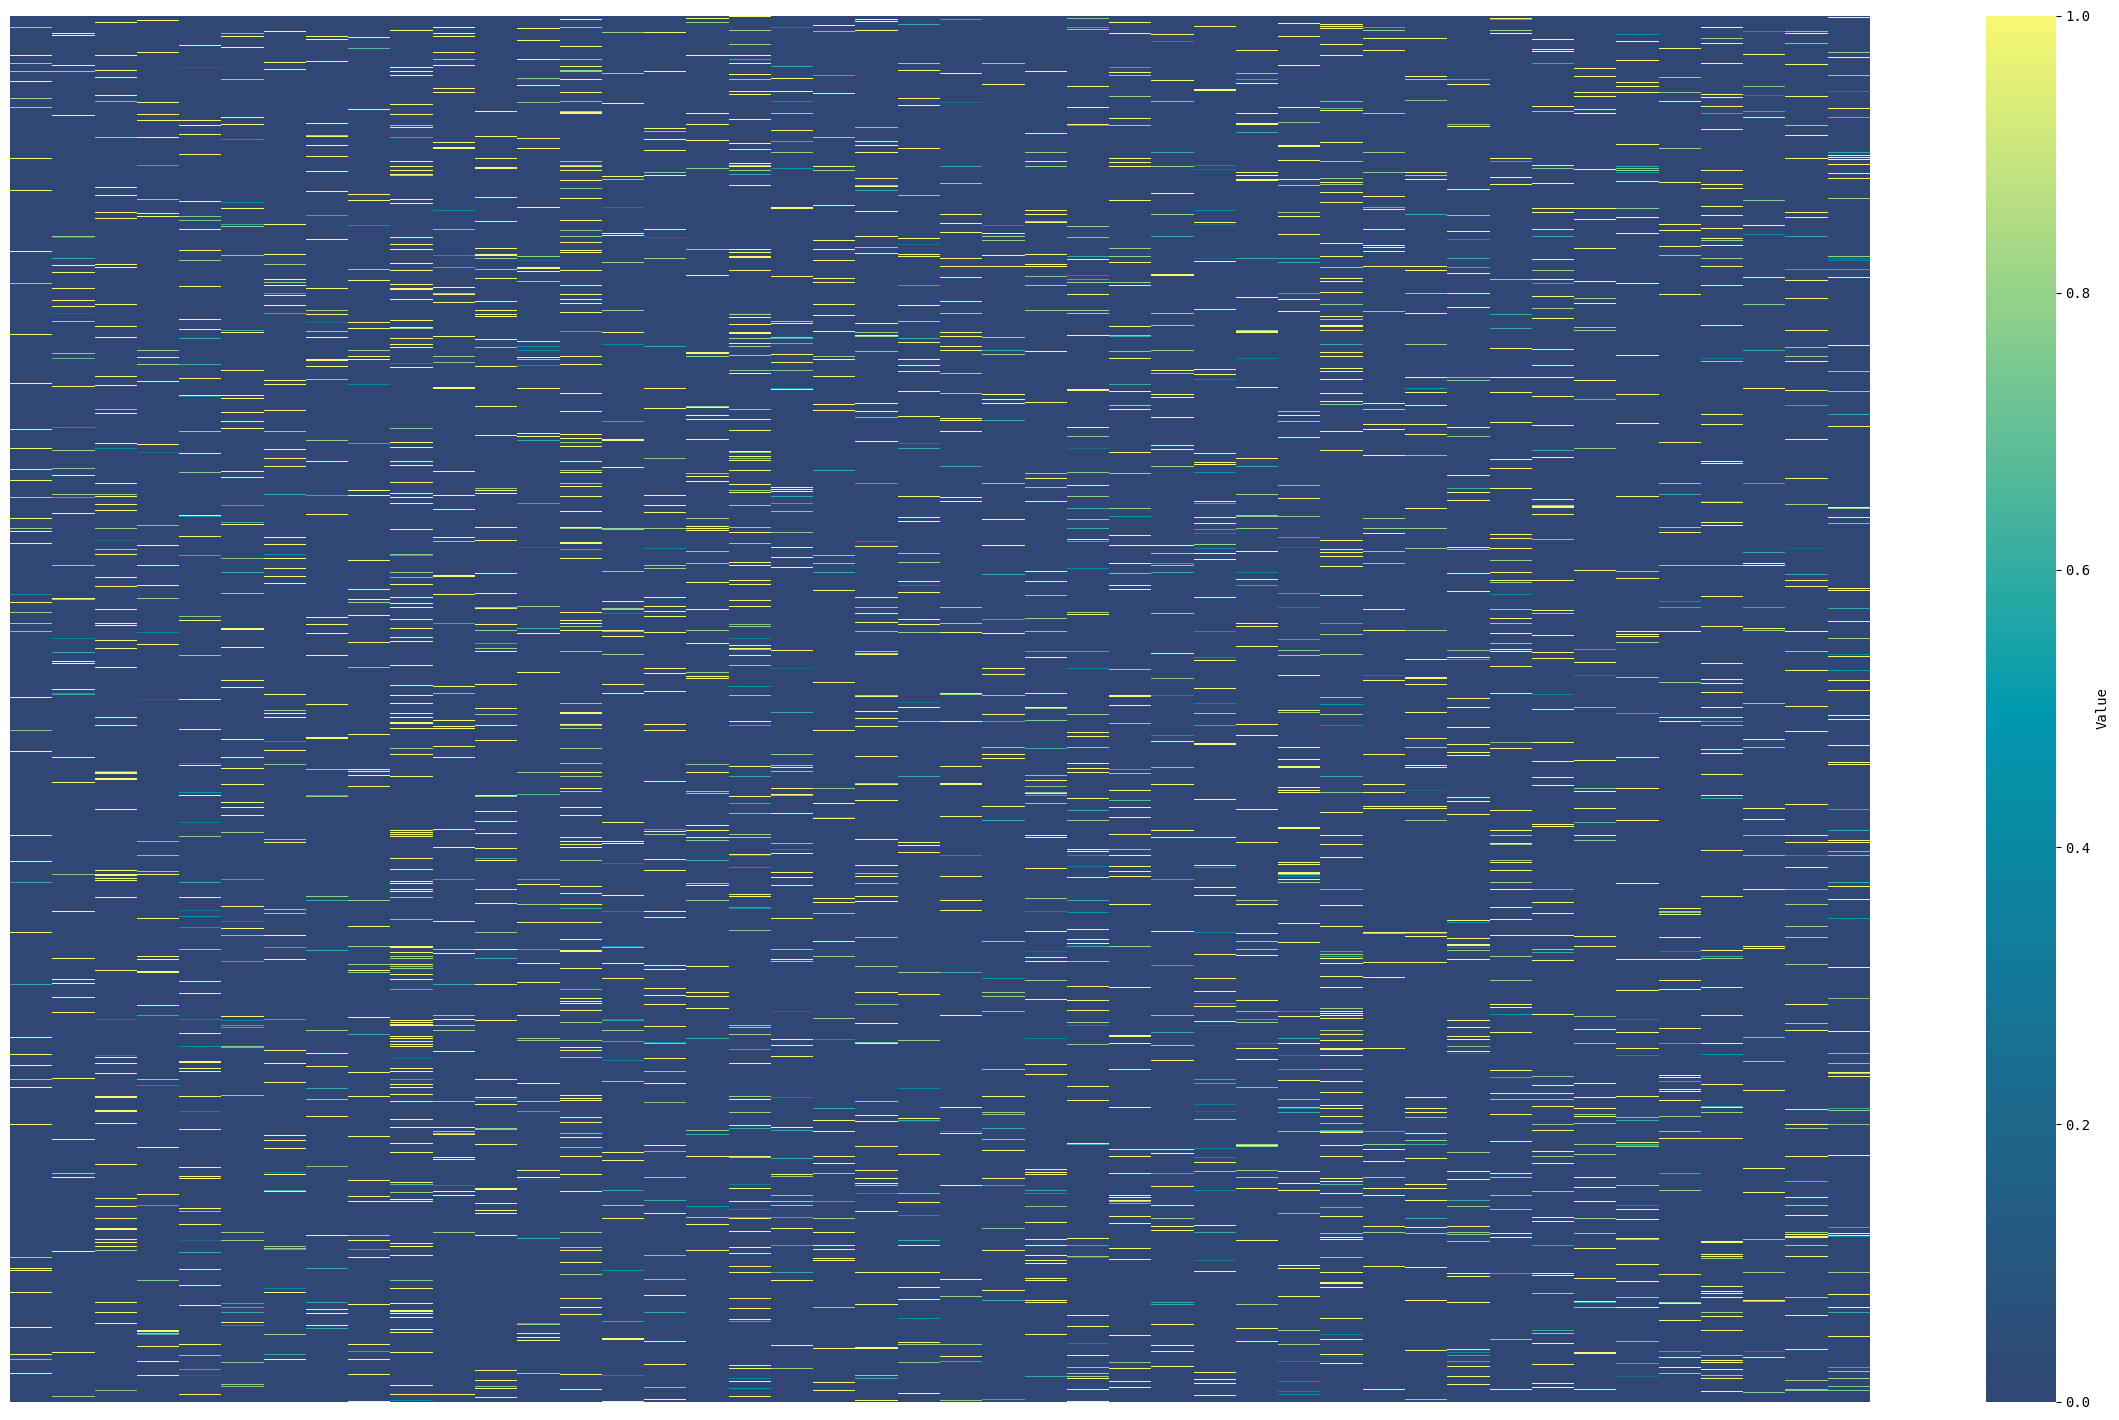

In [35]:
h.plot_large_heatmap(normalized_matrix)